In [1]:
#Compilo todo el codigo (Es lo mismo que hace la notebook knn, es para tenerlo a mano)
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Found libomp without any special flags
-- Found PythonInterp: /home/ivanb/Desktop/UBA/MetodosNumericos/tp2-metodos-numericos/tp2/bin/python (found version "3.8.5") 
-- Found PythonLibs: /u

# Imports y algoritmos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import metnum as mn
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, recall_score
from time import time
import seaborn as sns
from skimage import io

In [3]:
#Algoritmo de kFold
def kFold(K,sizeX):
    kfold = []
    aux = 0
    tamañoDelFold = np.ceil(sizeX/K)
    while(aux < sizeX):
        indice = aux+tamañoDelFold
        if(indice > sizeX):
            indice = sizeX
            
        indices = [int(aux),int(indice)]
        kfold.append(indices)
        aux += tamañoDelFold
    return kfold

#Algoritmo de crossValidation
def kFoldCrossValidation(k,K,X,y,alpha=0):
    kfold = kFold(K,X.shape[0])
    sumKappa,sumAcc,sumF1,sumRecall = 0,0,0,0
    result = []
    X_copy = X
    
    if(alpha != 0):
        pca = mn.PCA(alpha)
        pca.fit(X_copy)
        X_copy = pca.transform(X_copy)
        
    for i in range(len(kfold)):
        aux = kfold[i]
        #Separo el data set en datos de entrenamiento y de validacion
        X_test = X_copy[aux[0]:aux[1]]
        y_test = y[aux[0]:aux[1]]
        X_train = np.concatenate((X_copy[:aux[0]+1], X_copy[aux[1]:]), axis=0)
        y_train = np.concatenate((y[:aux[0]+1], y[aux[1]:]), axis=0)

        #Hago una prediccion con mi modelo
        model = mn.KNNClassifier(k)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)

        #Sumamos las metricas
        sumKappa += cohen_kappa_score(y_test, y_pred)
        sumAcc += accuracy_score(y_test, y_pred)
        sumF1 += f1_score(y_test, y_pred, average="macro")
        sumRecall += recall_score(y_test, y_pred, average="macro")
    
    result = [sumKappa,sumAcc,sumF1,sumRecall]
    result = list(map(lambda x: x / len(kfold), result))
    
    return result

# Analisis Dataset

In [4]:
#Me guardo los datos de entrenamiento
df = pd.read_csv("../data/train.csv")

In [5]:
df_cortado = df[:25000]
#Divido el dataset en train y test (Importante el random_state para salvar el caso donde el dataset esta ordenado)
df_train, df_test = train_test_split(df_cortado, test_size = 0.30, random_state = 69)

In [6]:
#Me guardo las imagenes y los labels por separado
X_train = df_train[df_train.columns[1:]].values
y_train = df_train["label"].values.reshape(-1,1)
X_test = df_test[df_test.columns[1:]].values
y_test = df_test["label"].values.reshape(-1,1)

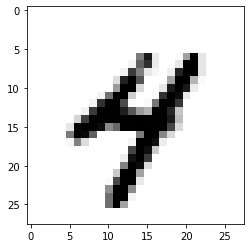

In [7]:
plt.imshow(X_train[0].reshape(28,28), interpolation='nearest', cmap='Greys')
plt.show()

In [8]:
df.shape[0]

42000

In [9]:
X_test.shape

(7500, 784)

In [ ]:
X_train.shape

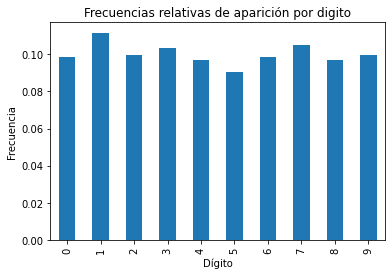

In [10]:
#Balance de datos
value_counts = df["label"].value_counts(normalize=True,sort=False)
value_counts.plot(kind = 'bar')
plt.xlabel('Dígito')
plt.ylabel('Frecuencia')
plt.title('Frecuencias relativas de aparición por digito')
plt.show()

# Experimentación

## kNN sin PCA

In [11]:
#Consigo metricas para k de 1 a 40
K = 10
listaDeKs = range(1,40)

metricas_sinPCA = []
for k in listaDeKs:
    metricas_sinPCA.append(kFoldCrossValidation(k,K,X_train,y_train))

In [12]:
#Me guardo las metricas por separado
kappa_sinPCA,acc_sinPCA,f1_sinPCA,recall_sinPCA = [],[],[],[]
for i in metricas_sinPCA:
    kappa_sinPCA.append(i[0])
    acc_sinPCA.append(i[1])
    f1_sinPCA.append(i[2])
    recall_sinPCA.append(i[3])

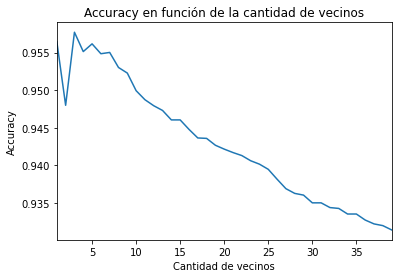

In [13]:
#Vemos como se mueve accuracy en funcion del k elegido
plt.plot(listaDeKs,acc_sinPCA)
plt.xlim(1,len(listaDeKs),1)
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Accuracy')
plt.title('Accuracy en función de la cantidad de vecinos')
plt.show()

In [14]:
#Conseguimos el maximo
print('El maximo es: ',max(acc_sinPCA), 'y se consigue con k =',acc_sinPCA.index(max(acc_sinPCA))+1)

El maximo es:  0.9577142857142856 y se consigue con k = 3


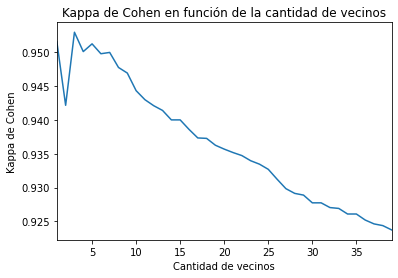

In [15]:
#Vemos como se mueve la Kappa de Cohen en funcion del k elegido
plt.plot(listaDeKs,kappa_sinPCA)
plt.xlim(1,len(listaDeKs),1)
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Kappa de Cohen')
plt.title('Kappa de Cohen en función de la cantidad de vecinos')
plt.show()

In [16]:
#Conseguimos el maximo
print('El maximo es: ',max(kappa_sinPCA), 'y se consigue con k =',kappa_sinPCA.index(max(kappa_sinPCA))+1)

El maximo es:  0.9529722437570399 y se consigue con k = 3


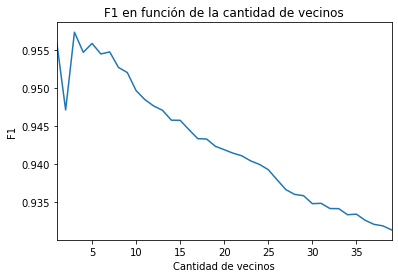

In [17]:
#Vemos como se mueve f1 en funcion del k elegido
plt.plot(listaDeKs,f1_sinPCA)
plt.xlim(1,len(listaDeKs),1)
plt.xlabel('Cantidad de vecinos')
plt.ylabel('F1')
plt.title('F1 en función de la cantidad de vecinos')
plt.show()

In [18]:
#Conseguimos el maximo
print('El maximo es: ',max(f1_sinPCA), 'y se consigue con k =',f1_sinPCA.index(max(f1_sinPCA))+1)

El maximo es:  0.9572870069436066 y se consigue con k = 3


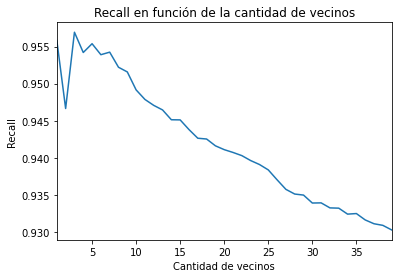

In [19]:
#Vemos como se mueve Recall en funcion del k elegido
plt.plot(listaDeKs,recall_sinPCA)
plt.xlim(1,len(listaDeKs),1)
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Recall')
plt.title('Recall en función de la cantidad de vecinos')
plt.show()

In [20]:
#Conseguimos el maximo
print('El maximo es: ',max(recall_sinPCA), 'y se consigue con k =',recall_sinPCA.index(max(recall_sinPCA))+1)

El maximo es:  0.95692477411275 y se consigue con k = 3


## Tiempo de ejecucion segun el k elegido

In [86]:
#Calculo el tiempo de ejecucion promedio para varios k
listaDeKs = range(1,40)
times_sin_PCA = []

for k in listaDeKs:
    start_time = time()
    for i in range(5):
        model_time = mn.KNNClassifier(k)
        model_time.fit(X_train,y_train)
        model_time.predict(X_test)
    times_sin_PCA.append((time()-start_time)/5)

KeyboardInterrupt: 

In [ ]:
#Veo el tiempo que tarda el algoritmo en funcion del k elegido
#Vemos como se mueve Recall en funcion del k elegido
plt.plot(listaDeKs,times_sin_PCA)
plt.xlim(1,len(listaDeKs),1)
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Tiempo (Segundos)')
plt.title('Tiempo de ejecución variando la cantidad de vecinos')
plt.show()

## kNN con PCA

In [23]:
#Consigo metricas para alpha de 1 a 100
lista_alphas = range(1,100)
K = 10
k = 3
metricas_conPCA = []

for alpha in lista_alphas:
    metricas_conPCA.append(kFoldCrossValidation(k,K,X_train,y_train,alpha))

In [24]:
#Me guardo las metricas por separado
kappa_conPCA,acc_conPCA,f1_conPCA,recall_conPCA = [],[],[],[]
for i in metricas_conPCA:
    kappa_conPCA.append(i[0])
    acc_conPCA.append(i[1])
    f1_conPCA.append(i[2])
    recall_conPCA.append(i[3])

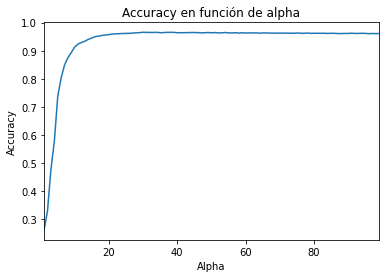

In [25]:
#Vemos como se mueve accuracy en funcion del alpha elegido
plt.plot(lista_alphas,acc_conPCA)
plt.xlim(1,len(lista_alphas),1)
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy en función de alpha')
plt.show()

In [26]:
#Conseguimos el maximo
print('El maximo es: ',max(acc_conPCA), 'y se consigue con alpha =',acc_conPCA.index(max(acc_conPCA))+1)

El maximo es:  0.9658285714285716 y se consigue con alpha = 30


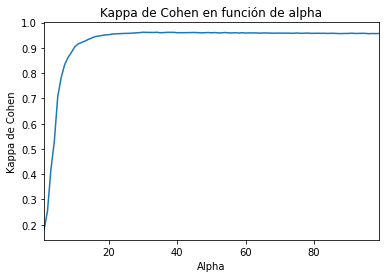

In [27]:
#Vemos como se mueve kappa de Cohen en funcion del alpha elegido
plt.plot(lista_alphas,kappa_conPCA)
plt.xlim(1,len(lista_alphas),1)
plt.xlabel('Alpha')
plt.ylabel('Kappa de Cohen')
plt.title('Kappa de Cohen en función de alpha')
plt.show()

In [28]:
#Conseguimos el maximo
print('El maximo es: ',max(kappa_conPCA), 'y se consigue con alpha =',kappa_conPCA.index(max(kappa_conPCA))+1)

El maximo es:  0.9620011509913924 y se consigue con alpha = 30


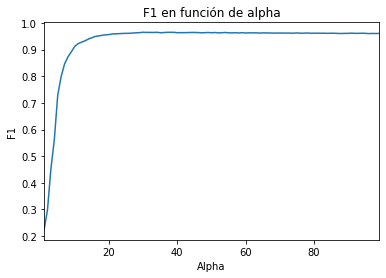

In [29]:
#Vemos como se mueve f1 en funcion del alpha elegido
plt.plot(lista_alphas,f1_conPCA)
plt.xlim(1,len(lista_alphas),1)
plt.xlabel('Alpha')
plt.ylabel('F1')
plt.title('F1 en función de alpha')
plt.show()

In [30]:
#Conseguimos el maximo
print('El maximo es: ',max(f1_conPCA), 'y se consigue con alpha =',f1_conPCA.index(max(f1_conPCA))+1)

El maximo es:  0.9653469121492936 y se consigue con alpha = 30


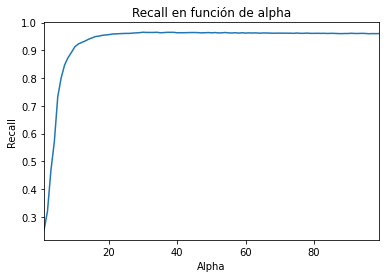

In [31]:
#Vemos como se mueve recall en funcion del alpha elegido
plt.plot(lista_alphas,recall_conPCA)
plt.xlim(1,len(lista_alphas),1)
plt.xlabel('Alpha')
plt.ylabel('Recall')
plt.title('Recall en función de alpha')
plt.show()

In [32]:
#Conseguimos el maximo
print('El maximo es: ',max(recall_conPCA), 'y se consigue con alpha =',recall_conPCA.index(max(recall_conPCA))+1)

El maximo es:  0.9654304408061852 y se consigue con alpha = 30


## Tiempo de ejecucion segun el alpha elegido

In [80]:
#Calculo el tiempo de ejecución promedio para varios alphas
listaDeAlphas = range(1,50)
times_con_PCA = []

for alpha in listaDeAlphas:
    start_time = time()
    for i in range(5):
        pca_time = mn.PCA(alpha)
        pca_time.fit(X_train)
        pca_time.transform(X_train)
    times_con_PCA.append((time()-start_time)/5)

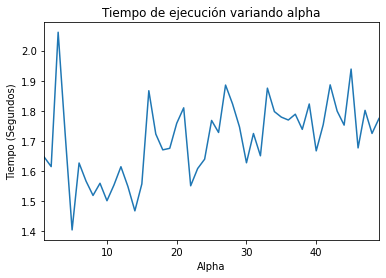

In [81]:
#Veo el tiempo que tarda el algoritmo en funcion del k elegido
#Vemos como se mueve Recall en funcion del k elegido
plt.plot(listaDeAlphas,times_con_PCA)
plt.xlim(1,len(listaDeAlphas),1)
plt.xlabel('Alpha')
plt.ylabel('Tiempo (Segundos)')
plt.title('Tiempo de ejecución variando alpha')
plt.show()

## Mejor Combinación k y alpha

Idea: Hacer una función que

- Encontre la mejor combinación de alpha y k. 
- Devuelva un vector con la mejor combinación [k,alpha] y 4 matrices con el valor de accuracy,... para cada combinación 

Con esa información, hacer un heatmap.

In [35]:
#Algoritmo de combinacion
def bestCombination(X,y,k,alpha,K=10):
    
    matriz_resultado_acc = []
    matriz_resultado_kappa = []
    matriz_resultado_F1 = []
    matriz_resultado_Recall = []
    
    vector_mejor_comb = []
    
    for i in range(4):
        vector_mejor_comb.append([0,0,0])
    
    for alpha_j in alpha:
        # Creo la fila de la matriz res correspodiente a alpha_j fijo y variar k
        vector_alpha_j_acc = []
        vector_alpha_j_kappa = []
        vector_alpha_j_F1 = []
        vector_alpha_j_Recall = []
        
        # Lleno la fila
        for k_i in k:
            combinacion_k_apl = kFoldCrossValidation(k_i,K,X,y,alpha=alpha_j) #[Kappa,Acc,F1,Recall]
            
            # Agrego la métrica con accuracy a la matriz. Además, veo si es la mejor combianción de k y alpha respecto de accuracy.
            vector_alpha_j_acc.append(combinacion_k_apl[1])
            if (combinacion_k_apl[1] > vector_mejor_comb[0][2]):
                vector_mejor_comb[0] = [k_i,alpha_j,combinacion_k_apl[1]]

            # Agrego la métrica con kappa a la matriz. Además, veo si es la mejor combianción de k y alpha respecto de kappa.
            vector_alpha_j_kappa.append(combinacion_k_apl[0])
            if (combinacion_k_apl[0] > vector_mejor_comb[1][2]):
                vector_mejor_comb[1] = [k_i,alpha_j,combinacion_k_apl[0]]
            
            # Agrego la métrica con F1 a la matriz. Además, veo si es la mejor combianción de k y alpha respecto de F1.
            vector_alpha_j_F1.append(combinacion_k_apl[2])
            if (combinacion_k_apl[2] > vector_mejor_comb[2][2]):
                vector_mejor_comb[2] = [k_i,alpha_j,combinacion_k_apl[2]]
            
            # Agrego la métrica con Recall a la matriz. Además, veo si es la mejor combianción de k y alpha respecto de Recall.
            vector_alpha_j_Recall.append(combinacion_k_apl[3])
            if (combinacion_k_apl[3] > vector_mejor_comb[3][2]):
                vector_mejor_comb[3] = [k_i,alpha_j,combinacion_k_apl[3]]
        
        matriz_resultado_acc.append(vector_alpha_j_acc)
        matriz_resultado_kappa.append(vector_alpha_j_kappa)
        matriz_resultado_F1.append(vector_alpha_j_F1)
        matriz_resultado_Recall.append(vector_alpha_j_Recall)
    
        lista_matrices = [matriz_resultado_acc, matriz_resultado_kappa, matriz_resultado_F1, matriz_resultado_Recall]
    
    return lista_matrices, vector_mejor_comb
    # lista_matrices = Matriz que usa el heatmap. Cada fila es para un alpha fijo y un k variable. La lista tiene las matrices respecto de accuracy, kappa, F1 y Recall en ese orden
    # vector_mejor_comb = Mejor comb de k, alpha, y su métrica asociada (en ese orden). La lista tiene las métriicas respecto de accuracy, kappa, F1 y Recall en ese orden

In [36]:
k = np.arange(1,11,1)
alpha = np.arange(30,61,2)

bestComb_m, bestComb_v = bestCombination(X_train,y_train,k,alpha)

### Accuracy

Text(0.5, 1.0, 'Accuracy en función de la cantidad de vecinos y alpha')

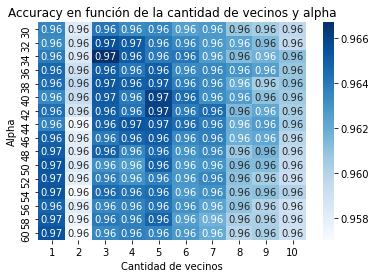

In [37]:
matriz_accuracy = bestComb_m[0]

x_axis_labels = k # labels for x-axis
y_axis_labels = alpha # labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(matriz_accuracy, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="Blues")

plt.xlabel("Cantidad de vecinos") 
plt.ylabel("Alpha")
plt.title('Accuracy en función de la cantidad de vecinos y alpha')

In [38]:
bestComb_v[0]

[3, 34, 0.9666857142857144]

### Kappa

Text(0.5, 1.0, 'Kappa de Cohen en función de la cantidad de vecinos y alpha')

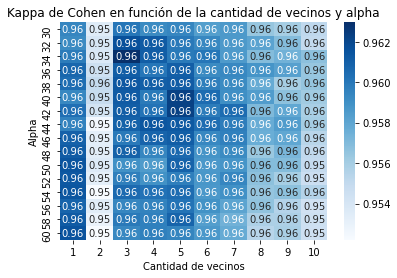

In [39]:
matriz_kappa = bestComb_m[1]

x_axis_labels = k # labels for x-axis
y_axis_labels = alpha # labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(matriz_kappa, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="Blues")

plt.xlabel("Cantidad de vecinos") 
plt.ylabel("Alpha")
plt.title('Kappa de Cohen en función de la cantidad de vecinos y alpha')

In [40]:
bestComb_v[1]

[3, 34, 0.9629540014636231]

### F1

Text(0.5, 1.0, 'F1 en función de la cantidad de vecinos y alpha')

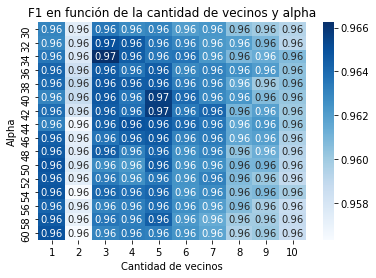

In [41]:
matriz_f1 = bestComb_m[2]

x_axis_labels = k # labels for x-axis
y_axis_labels = alpha # labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(matriz_f1, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="Blues")

plt.xlabel("Cantidad de vecinos") 
plt.ylabel("Alpha")
plt.title('F1 en función de la cantidad de vecinos y alpha')

In [42]:
bestComb_v[2]

[3, 34, 0.9662410515424105]

### Recall

Text(0.5, 1.0, 'Recall en función de la cantidad de vecinos y alpha')

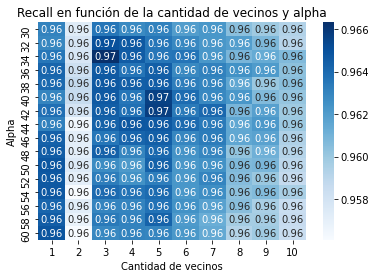

In [43]:
matriz_recall = bestComb_m[3]

x_axis_labels = k # labels for x-axis
y_axis_labels = alpha # labels for y-axis

# create seabvorn heatmap with required labels
sns.heatmap(matriz_recall, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap="Blues")

plt.xlabel("Cantidad de vecinos") 
plt.ylabel("Alpha")
plt.title('Recall en función de la cantidad de vecinos y alpha')

In [44]:
bestComb_v[3]

[3, 34, 0.9663139797253294]

# Predicciones de datos de Test

In [165]:
#Uso mi modelo para clasificar los digitos usando PCA
X_train_transform = X_train
X_test_transform = X_test

#Hago PCA tanto al train como a nuestro dataframe
pca = mn.PCA(56)
pca.fit(X_train_transform)
X_train_transform = pca.transform(X_train_transform)
X_test_transform = pca.transform(X_test_transform)

In [166]:
#Uso el modelo para los dato con PCA
model = mn.KNNClassifier(1)
model.fit(X_train_transform,y_train)
y_pred_test = model.predict(X_test_transform)
#Veo el accuracy conseguido
accuracy_score(y_test, y_pred_test)

0.966

In [167]:
#Hago lo mismo pero sin usar PCA
model = mn.KNNClassifier(3)
model.fit(X_train,y_train)
y_pred_test = model.predict(X_test)
#Veo el accuracy conseguido
accuracy_score(y_test, y_pred_test)

0.9598666666666666

# Predicciones de digitos dibujados por el equipo

In [133]:
#Este es el algoritmo para parsear las imagenes al formato que queremos
def parse_image(imagen):
    #Lista donde guardaremos la imagen row-major
    image_array = []
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #Nos guardamos el alpha ya que es el unico canal que nos importa al estar en escala de grises
            image_array.append(image[i][j][3])
            
    #Devolvemos la imagen como un array de numpy
    return np.asarray(image_array).reshape(784)

In [134]:
#Guardo todas las imagenes de la carpeta en colecciones separadas segun digito
imagenes0 = io.imread_collection('nuestrosdigitos/0-*.png')
imagenes1 = io.imread_collection('nuestrosdigitos/1-*.png')
imagenes2 = io.imread_collection('nuestrosdigitos/2-*.png')
imagenes3 = io.imread_collection('nuestrosdigitos/3-*.png')
imagenes4 = io.imread_collection('nuestrosdigitos/4-*.png')
imagenes5 = io.imread_collection('nuestrosdigitos/5-*.png')
imagenes6 = io.imread_collection('nuestrosdigitos/6-*.png')
imagenes7 = io.imread_collection('nuestrosdigitos/7-*.png')
imagenes8 = io.imread_collection('nuestrosdigitos/8-*.png')
imagenes9 = io.imread_collection('nuestrosdigitos/9-*.png')

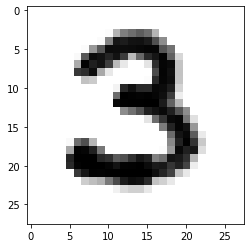

In [135]:
#Vemos uno de los digitos dibujados
plt.imshow(imagenes3[3],vmin=0,vmax=1)

In [136]:
#Me guardo todos los conjuntos de imagenes en una lista
imagenes_nuestras = [imagenes0, imagenes1, imagenes2, imagenes3, imagenes4, imagenes5, imagenes6, imagenes7, imagenes8, imagenes9]

In [137]:
#Creo el vector de verificacion a mano (pues ya se en que orden se encontrara el dataset)
clasificaciones_esperadas = []
for i in range(10):
    for j in range(len(imagenes0)):
        clasificaciones_esperadas.append(i)
clasificaciones_esperadas = np.array(clasificaciones_esperadas)

In [138]:
#Parseo los datos al formato que usamos en el algoritmo
#Nos quedara ordenado, es decir, primero todos los ceros, luego todos los unos y asi siguiendo hasta el nueve
nuestro_df = []
for conjunto_imagenes in imagenes_nuestras:
    for image in conjunto_imagenes:
        nuestro_df.append(parse_image(image))
    
nuestro_df = np.array(nuestro_df)

In [152]:
#Uso mi modelo para clasificar los digitos con PCA y sin PCA
X_train_PCA = X_train
nuestro_df_PCA = nuestro_df

#Hago PCA tanto al train como a nuestro dataframe
pca = mn.PCA(56)
pca.fit(X_train_PCA)
X_train_PCA = pca.transform(X_train_PCA)
nuestro_df_PCA = pca.transform(nuestro_df_PCA)

In [153]:
#Uso el modelo para los dato SIN PCA
model = mn.KNNClassifier(3)
model.fit(X_train,y_train)
y_pred_noPCA = model.predict(nuestro_df)
#Veamos el accuracy conseguido
accuracy_score(clasificaciones_esperadas, y_pred_noPCA)

0.6

In [154]:
y_pred_noPCA

array([3., 0., 0., 0., 1., 1., 1., 1., 2., 0., 3., 2., 3., 3., 3., 3., 4.,
       4., 9., 4., 5., 5., 5., 5., 0., 5., 5., 6., 7., 7., 1., 1., 3., 3.,
       8., 3., 4., 4., 4., 4.])

In [155]:
#Uso el modelo para los dato con PCA
model = mn.KNNClassifier(1)
model.fit(X_train_PCA,y_train)
y_pred_PCA = model.predict(nuestro_df_PCA)
#Veo el accuracy conseguido
accuracy_score(clasificaciones_esperadas, y_pred_PCA)

0.6

In [156]:
y_pred_PCA

array([3., 0., 0., 0., 1., 7., 1., 1., 2., 0., 2., 2., 5., 3., 3., 3., 4.,
       4., 9., 4., 5., 5., 5., 5., 0., 6., 9., 6., 7., 7., 1., 1., 3., 3.,
       8., 3., 4., 4., 8., 4.])

In [157]:
clasificaciones_erroneas_noPCA = clasificaciones_esperadas - y_pred_noPCA
clasificaciones_erroneas_PCA = clasificaciones_esperadas - y_pred_PCA

In [158]:
clasificaciones_erroneas_por_digito_PCA = []
clasificaciones_erroneas_por_digito_noPCA = []
i = 4
while i < 41:
    clasificaciones_erroneas_por_digito_PCA.append(clasificaciones_erroneas_PCA[i-4:i])
    clasificaciones_erroneas_por_digito_noPCA.append(clasificaciones_erroneas_noPCA[i-4:i])
    i += 4

In [159]:
clasificaciones_erroneas_PCA_count = []
clasificaciones_erroneas_noPCA_count = []

for i in clasificaciones_erroneas_por_digito_PCA:
    tmp = 0
    for j in range(4):
        if i[j] != 0:
            tmp += 1
    clasificaciones_erroneas_PCA_count.append(tmp)
    
for i in clasificaciones_erroneas_por_digito_noPCA:
    tmp = 0
    for j in range(4):
        if i[j] != 0:
            tmp += 1
    clasificaciones_erroneas_noPCA_count.append(tmp)

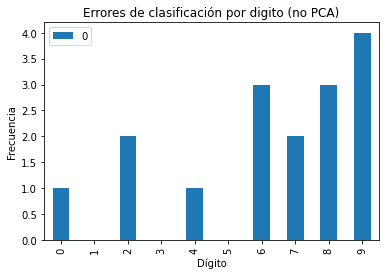

In [160]:
clasificaciones_erroneas_noPCA_count = pd.DataFrame(clasificaciones_erroneas_noPCA_count)
clasificaciones_erroneas_noPCA_count.plot(kind = 'bar')
plt.xlabel('Dígito')
plt.ylabel('Frecuencia')
plt.title('Errores de clasificación por digito (no PCA)')
plt.show()

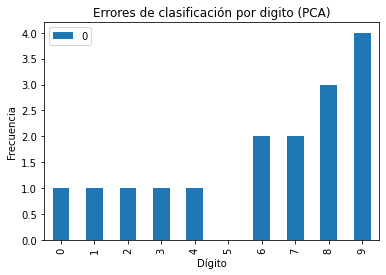

In [161]:
clasificaciones_erroneas_PCA_count = pd.DataFrame(clasificaciones_erroneas_PCA_count)
clasificaciones_erroneas_PCA_count.plot(kind = 'bar')
plt.xlabel('Dígito')
plt.ylabel('Frecuencia')
plt.title('Errores de clasificación por digito (PCA)')
plt.show()

In [162]:
clasificaciones_por_digito_PCA = []
clasificaciones_por_digito_noPCA = []
i = 4
while i < 41:
    clasificaciones_por_digito_PCA.append(list(map(int,y_pred_PCA[i-4:i])))
    clasificaciones_por_digito_noPCA.append(list(map(int,y_pred_noPCA[i-4:i])))
    i += 4

In [163]:
#Tabla de clasificaciones conseguidas usando PCA
clasificaciones_PCA = {'Digito': range(10), 'Clasificaciones': clasificaciones_por_digito_PCA}
clasificaciones_PCA = pd.DataFrame(clasificaciones_PCA)
clasificaciones_PCA

Digito Clasificaciones
0       0    [3, 0, 0, 0]
1       1    [1, 7, 1, 1]
2       2    [2, 0, 2, 2]
3       3    [5, 3, 3, 3]
4       4    [4, 4, 9, 4]
5       5    [5, 5, 5, 5]
6       6    [0, 6, 9, 6]
7       7    [7, 7, 1, 1]
8       8    [3, 3, 8, 3]
9       9    [4, 4, 8, 4]

In [164]:
#Tabla de clasificaciones conseguidas usando sin PCA
clasificaciones_noPCA = {'Digito': range(10), 'Clasificaciones': clasificaciones_por_digito_noPCA}
clasificaciones_noPCA = pd.DataFrame(clasificaciones_noPCA)
clasificaciones_noPCA

Digito Clasificaciones
0       0    [3, 0, 0, 0]
1       1    [1, 1, 1, 1]
2       2    [2, 0, 3, 2]
3       3    [3, 3, 3, 3]
4       4    [4, 4, 9, 4]
5       5    [5, 5, 5, 5]
6       6    [0, 5, 5, 6]
7       7    [7, 7, 1, 1]
8       8    [3, 3, 8, 3]
9       9    [4, 4, 4, 4]